# Exercise Sheet No. 2

---

> Machine Learning for Natural Sciences, Summer 2021, Jun.-Prof. Pascal Friederich, pascal.friederich@kit.edu
> 
> Deadline: 26.04.2021, 8am

---

# Preliminaries
In this exercise we use pandas, numpy, networkx (graph library), and pyvis (graph visualization). Those packages should already be installed in the `aimat` conda environment.  

If you get errors on import simply install those packages into your conda environment with:
```bash
conda activate aimat
conda install pandas
conda install networkx
pip install pyvis
```

# Introduction

This assignment consists of a brief pandas tutorial and an exercise on decision trees. The pandas tutorial is not graded, but the decision tree exercise is.

Table of contents
- [Pandas Tutorial](#Pandas-Tutorial)
    - [Series](#Series)
        - [Indexing Series](#Indexing-Series)
        - [Basic operations on Series](#Basic-operations-on-Series)
    - [DataFrames](#DataFrames)
        - [Inspection](#Inspection)
        - [Selecting data](#Selecting-data)
    - [Further reading](#Further-reading)
- [Decision Trees](#Decision-Trees)
    - [Preprocessing](#Preprocessing)
    - [Cost function](#Cost-function)
    - [Greedy strategy](#Greedy-strategy)
    - [Building the Tree](#Building-the-Tree)
        - [Splitting](#Splitting)
        - [_fit()](#_fit())
        - [_predict()](#_predict())
        - [Plotting](#Plotting)
- [Validation and hyperparameter tuning](#Validation-and-hyperparameter-tuning)

# Pandas Tutorial
A major part in machine learning workflows is the data preprocessing with the often not trivial task to get data loaded into a numpy format an clean up the dataset. While doing this, it is also important to keep track of the dataset's meta data like column and row labels. Pandas is an open source python library that helps a lot with those workflows. Especially it offers a tabular data format which supports fast analysis and SQL-like operations. Under the hood pandas still stores the data in a numpy format, and therefore is also fast.

For the following decision tree task we will use the Iris dataset. This dataset contains the sepal and petal width and length for three different iris species (Schwertlilien):
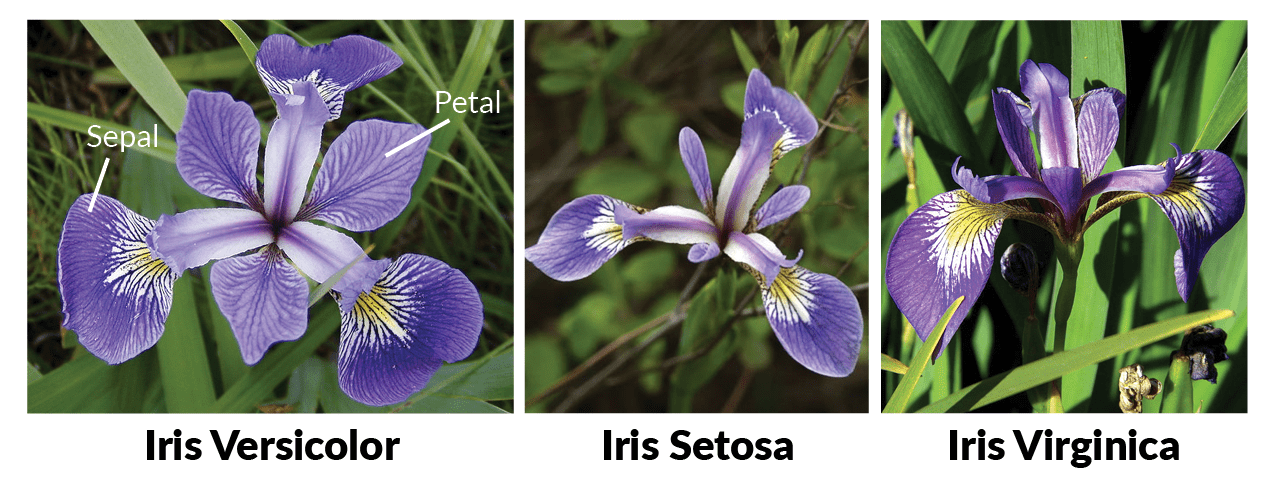

This is a common dataset to illustrate multi-class classification and we will use this later in our decision tree example to classify the species based on those measured leaf dimensions.

But first let's have a look at *pandas*!

## Series
A series in pandas is an one-dimensional object, like an array, but with additional meta data for every entry:

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
from pyvis.network import Network
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
colorblind = ['#0072B2',
              '#E69F00',
              '#F0E442',
              '#009E73',
              '#56B4E9',
              '#D55E00',
              '#CC79A7',
              '#000000'
             ]

In [3]:
series = pd.Series([42, 'is the answer!', 'Or', 42., '?'])
series

0                42
1    is the answer!
2                Or
3              42.0
4                 ?
dtype: object

### Indexing Series

You can also add a custom index to this series:

In [4]:
series = pd.Series([42, 'is the answer', 'or', 42., '?'],
                   index=['integer 1', 'string 1', 'string 2', 'float 1', 'string 3'])
series

integer 1               42
string 1     is the answer
string 2                or
float 1               42.0
string 3                 ?
dtype: object

The great thing is that pandas infers datatypes automatically. Instead of the index constructor we can also simply use a dictionary:

In [5]:
petal_length = pd.Series({0: 5.1, 1: 4.9, 2: None, 3: 4.6, 4: 5.0, 5: 5.4})
petal_length

0    5.1
1    4.9
2    NaN
3    4.6
4    5.0
5    5.4
dtype: float64

Here the whole Series contains the same datatype and `None` is automatically converted into a numpy `NaN` (not-a-number) value.

We can now get single elements from the series similar to indexing in python:


In [6]:
petal_length[0]

np.float64(5.1)

In [7]:
petal_length[0:2]

0    5.1
1    4.9
dtype: float64

In [8]:
petal_length[[0, 2, 4]]

0    5.1
2    NaN
4    5.0
dtype: float64

Another handy feature of pandas is that it can return boolean masks for Series, applying a logical operation for each element:

In [9]:
petal_length > 5

0     True
1    False
2    False
3    False
4    False
5     True
dtype: bool

The `NaN` can be handled here without causing an error.

We can use this mask directly as a boolean index to return only the subset of the Series that fulfills this condition:

In [10]:
petal_length[petal_length > 5]

0    5.1
5    5.4
dtype: float64

As a Series is an iterable, we can also use the `in` keyword:

In [11]:
5 in petal_length

True

In [12]:
5.1 in petal_length

False

Be aware, that this works only on the index! To only work on the values of the series we can use the `values` attribute. This basically strips away all the meta data and simply returns the values without keys as numpy array:

In [13]:
petal_length.values

array([5.1, 4.9, nan, 4.6, 5. , 5.4])

In [14]:
5.1 in petal_length.values

True

### Basic operations on Series

You can apply mathematical operations on series like you would do in numpy:

In [15]:
petal_length/2

0    2.55
1    2.45
2     NaN
3    2.30
4    2.50
5    2.70
dtype: float64

In [16]:
np.mean(petal_length)

np.float64(5.0)

In [17]:
np.sum(petal_length) / petal_length.shape[0]

np.float64(4.166666666666667)

Here again the numpy `NaN` is handled correctly and the correct mean of 5.0 is returned by the numpy `mean` method.

We can also use an addition of two series:

In [18]:
petal_length[0:4]

0    5.1
1    4.9
2    NaN
3    4.6
dtype: float64

In [19]:
petal_length[2:6]

2    NaN
3    4.6
4    5.0
5    5.4
dtype: float64

In [20]:
petal_length[0:4]+petal_length[2:6]

0    NaN
1    NaN
2    NaN
3    9.2
4    NaN
5    NaN
dtype: float64

What happened there? Well, when using series, pandas minds the index for the operation. It created a union of the two series and returned `NaN` for every value that didn't exist in both indicies. As only the value with index `3` was overlapping between the two slices, pandas only calculated the sum for this element.

Now we can also filter out `NaN`s or `None`s:

In [21]:
petal_length.isnull()

0    False
1    False
2     True
3    False
4    False
5    False
dtype: bool

In [22]:
petal_length.notnull()

0     True
1     True
2    False
3     True
4     True
5     True
dtype: bool

In [23]:
petal_length.dropna()

0    5.1
1    4.9
3    4.6
4    5.0
5    5.4
dtype: float64

In [24]:
petal_length

0    5.1
1    4.9
2    NaN
3    4.6
4    5.0
5    5.4
dtype: float64

Be aware, that `dropna()` returns the modified series without modifying the original series. Many pandas methods therefore have a boolean `inplace` argument:

In [25]:
petal_length.dropna(inplace=True)  # This returns nothing

In [26]:
petal_length

0    5.1
1    4.9
3    4.6
4    5.0
5    5.4
dtype: float64

## DataFrames

DataFrames are a tabular data format similar to spreadsheets or SQL tables. They have `columns` and an `index`. Basically rows in the dataframe are series with a shared index, the columns. And columns in the dataframe are series that share the index.

Pandas provides a whole toolbox of useful input-output methods for simple csv files, excel spread sheets, binary HDF5 formats, connections to SQL tables, etc. For more details refer to the [IO Documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html).

For this notebook we will only use the csv IO of pandas:

In [27]:
df = pd.read_csv("iris.csv")
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


Pandas integrates well with ipython and - as you can see - renders dataframes already in a nice HTML format.

### Inspection
Additionally, pandas provides a whole bunch of inspection tools to get an overview of your data. E.g. you can use the `columns` and `index` attributes to get the column and row labels:

In [28]:
df.columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width',
       'species'],
      dtype='object')

In [29]:
df.index

RangeIndex(start=0, stop=150, step=1)

Then several inspection methods get you meta data and statistics of the dataframe:

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [31]:
df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [32]:
df.shape

(150, 5)

Especially for larger dataframes it is useful to see only a subset of the data:

In [33]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [34]:
df.tail(3)

,sepal_length,sepal_width,petal_length,petal_width,species
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [35]:
df[70:75]

,sepal_length,sepal_width,petal_length,petal_width,species
70,5.9,3.2,4.8,1.8,Iris-versicolor
71,6.1,2.8,4.0,1.3,Iris-versicolor
72,6.3,2.5,4.9,1.5,Iris-versicolor
73,6.1,2.8,4.7,1.2,Iris-versicolor
74,6.4,2.9,4.3,1.3,Iris-versicolor


Pandas also provides integrated plotting based on matplotlib:

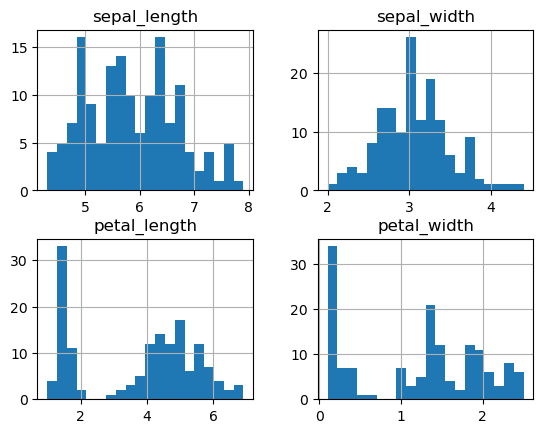

In [36]:
df.hist(bins=20)
plt.show()

# .hist() 是 DataFrame 自带的方法，用来对每个数值型列绘制直方图。
# bins=20 表示把每个特征的数值范围划分为 20 个区间（即 20 个柱子）。

We can also inspect categorical values with pandas:

In [37]:
df['species'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [38]:
df['species'].value_counts()

species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64

This also works for non-categorical data:

In [39]:
df['sepal_length'].value_counts()

sepal_length
5.0    10
6.3     9
5.1     9
6.7     8
5.7     8
6.4     7
5.5     7
5.8     7
4.9     6
6.0     6
5.4     6
5.6     6
6.1     6
6.5     5
4.8     5
7.7     4
6.9     4
4.6     4
5.2     4
6.2     4
4.4     3
7.2     3
5.9     3
6.8     3
4.7     2
6.6     2
4.3     1
7.0     1
5.3     1
4.5     1
7.1     1
7.3     1
7.6     1
7.4     1
7.9     1
Name: count, dtype: int64

### Selecting data

In pandas you can select data in multiple ways. First of all you can select only a subset of columns:

In [40]:
df[["sepal_length", "sepal_width"]]

,sepal_length,sepal_width
0,5.1,3.5
1,4.9,3.0
2,4.7,3.2
3,4.6,3.1
4,5.0,3.6
...,...,...
145,6.7,3.0
146,6.3,2.5
147,6.5,3.0
148,6.2,3.4


Furthermore, you can select ranges of the dataframe based on their **column and row index** with the `.loc[]` attribute and based on their **location** in the column and row with the `.iloc[]` attribute:

In [41]:
df.loc[10:15, "sepal_length":"petal_length"]

,sepal_length,sepal_width,petal_length
10,5.4,3.7,1.5
11,4.8,3.4,1.6
12,4.8,3.0,1.4
13,4.3,3.0,1.1
14,5.8,4.0,1.2
15,5.7,4.4,1.5


In [42]:
df.iloc[10:15, 0:2]

,sepal_length,sepal_width
10,5.4,3.7
11,4.8,3.4
12,4.8,3.0
13,4.3,3.0
14,5.8,4.0


Notice here, that `iloc` works like the usual slicing in python, while `loc` includes the stop values. `iloc` hence also handles a step size:

In [43]:
df.iloc[0:20:5]

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
5,5.4,3.9,1.7,0.4,Iris-setosa
10,5.4,3.7,1.5,0.2,Iris-setosa
15,5.7,4.4,1.5,0.4,Iris-setosa


To access single cells use `at[]` or `iat[]:

In [44]:
df.at[10, 'sepal_width']

np.float64(3.7)

In [45]:
df.iat[10, 1]

np.float64(3.7)

Pandas can do much more than that, e.g. merging and joining dataframes in an SQL-like fashion, grouping data, creating indicies with multiple layers (`MultiIndex`), grouping data, interpolating missing values, etc.

So if you want to go more into detail consider some excellent tutorials:


## Further reading

- [A three part introduction to pandas by Greg Reda](https://gregreda.com/2013/10/26/intro-to-pandas-data-structures/)
- ["Modern pandas" by the pandas developer Tom Augspurger](http://tomaugspurger.github.io/modern-1-intro.html) is intended for a bit more advanced users. Especially the method chaining is pretty elegant and we will use it for preprocessing!


# Decision Trees

First you can apply your new knowledge on pandas to preprocess the dataset.

## Preprocessing

In the following we will use pandas method chaining to prepare the dataset. This is a best practice in datascience and if you've never heard of it, read about it [here](http://tomaugspurger.github.io/method-chaining).
The basic idea behind method chaining is that you can prepare a whole workflow on a dataset where each modification of the dataset is provided by one function that takes a dataframe as argument and returns a dataframe. To keep track of the modifications we then can use decorators that inspect the dataframe object on each function call. Those decorators are already provided in the following.

So you only need to implement the `load` function using panda's csv IO:

In [46]:
from functools import wraps
import os
def log_name(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        print(f"\n{func.__name__}:")
        return result
    return wrapper

def log_shape(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        print(f"\tshape: {result.shape}")
        return result
    return wrapper

def log_columns(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        print(f"\tcolumns: {result.columns.values}")
        return result
    return wrapper

@log_columns
@log_shape
@log_name
def load(df, path):
    """Loads the dataset from path."""
    full_path = os.path.join('d:/a_coding/ML_for_sci', path)
    df = pd.read_csv(full_path) # 要于load函数中直接读取full_path路径下的csv文件
    # raise NotImplementedError()
    return df

In [47]:
import os
os.getcwd()

'd:\\a_coding\\ML_for_sci'

In [48]:
df = pd.DataFrame()
df = load(df, 'iris.csv')
assert df.shape == (150, 5)


load:
	shape: (150, 5)
	columns: ['sepal_length' 'sepal_width' 'petal_length' 'petal_width' 'species']


Next [read about categorical datatypes in pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) and implement the function `convert_to_categorical` to convert a given column name to a categorical datatype in pandas.

In [49]:
@log_columns
@log_shape
@log_name
def convert_to_categorical(df, col_name: str):
    df[col_name] = df[col_name].astype("category")
    # raise NotImplementedError()
    return df

In [50]:
col_name = "species"
df = convert_to_categorical(df, col_name)
assert type(df[col_name].dtype) is pd.CategoricalDtype
print(df.dtypes)


convert_to_categorical:
	shape: (150, 5)
	columns: ['sepal_length' 'sepal_width' 'petal_length' 'petal_width' 'species']
sepal_length     float64
sepal_width      float64
petal_length     float64
petal_width      float64
species         category
dtype: object


Next fill the function `add_class_labels`, that adds the column 'class' to the dataset. E.g. this column should contain a 0 if the species of the row is 'Iris-setosa', a 1 if the species of the row is 'Iris-versicolor' and a 2 if the species is 'Iris-virginica'.

HINT: You can use the properties of the categorical dtype for an easy one-liner.

In [51]:
@log_columns
@log_shape
@log_name
# def add_class_labels(df):
    
#     if (df["species"] == "iris-setosa").all():
#         df.insert(df.shape[1], "class", 0)
#     elif (df["species"] == "iris-versicolor").all():
#         df.insert(df.shape[1], "class", 1)
#     else:
#         df.insert(df.shape[1], "class", 2)
#     # raise NotImplementedError()
#     return df
def add_class_labels(df):
    df.insert(
        df.shape[1], "class",
        pd.Categorical(
            df["species"],
            categories=["Iris-setosa", "Iris-versicolor", "Iris-virginica"],  # 顺序即 0/1/2
            ordered=True
        ).codes
    )
    return df

In [52]:
df = add_class_labels(df)
assert (df[df['species']=='Iris-setosa']['class'] == 0).all()


add_class_labels:
	shape: (150, 6)
	columns: ['sepal_length' 'sepal_width' 'petal_length' 'petal_width' 'species'
 'class']


Next use the dataframe `.pipe()` method to chain the previously implemented `load`, `convert_to_categorical`, and `add_class_labels` functions to one preprocessing step:

In [53]:
df = pd.DataFrame()
col_name = "species"
df = (
    df.pipe(load, 'iris.csv')
    .pipe(convert_to_categorical,"species") #pipe 用于链接多组函数 可以对dataframe一步就调用多组函数进行预处理
    .pipe(add_class_labels)
)


load:
	shape: (150, 5)
	columns: ['sepal_length' 'sepal_width' 'petal_length' 'petal_width' 'species']

convert_to_categorical:
	shape: (150, 5)
	columns: ['sepal_length' 'sepal_width' 'petal_length' 'petal_width' 'species']

add_class_labels:
	shape: (150, 6)
	columns: ['sepal_length' 'sepal_width' 'petal_length' 'petal_width' 'species'
 'class']


In [54]:
assert df.shape == (150, 6)

This might be a very short pipeline but it can become very handy if you have multiple preprocessing steps like interpolating `NaN` values, etc. and want to keep track of every step and rerun it in one go without running multiple cells in a notebook.

Now that we have the class labels, we can start implementing our first decision tree.

To be more precise, we will implement a
- **binary**: each node stands for a split into two classes
- **classification**: we want to decide based on the features of the leaves to which iris species the flower belongs to
- **tree**: okay that one is self-explanatory...

So each split involves one of the four features and one condition (e.g. `petal_width < 1.1`). With each split we want to reduce the impurity of the resulting leaves as much as possible. To define this impurity we first need to define a cost function:

## Cost function

From the lecture you already know several cost functions. We will implement the entropy measure:

In information theory entropy is a measure of the average uncertainty in a random variable. Referring to a split of the dataset, the entropy tells us about the randomness in each part of the dataset.
It is defined as:
\begin{align}
H(X) &= - \sum_i^n p_i(x) \cdot log_2(p_i(x))
\end{align}
Each possible realization $x$ (each possible class label) of the discrete random variable $X$ (the class) has a given probability to occur. E.g. in our initial dataset the probability for each class label is $\frac{1}{3}$.  
Entropy is basically a weighted sum of the logarithm of these probabilities.  
Here we use the base $2$ for the logarithm to calculate the entropy in *bits*, using the natural logarithm of base $e$ would return the entropy in *nats*. Our random variable $X$ here is the class label.  

When there is only one possible realization $x$ of $X$ - for our application all class labels for a subset of the dataset are the same - what would be the entropy of $X$? Assign the value of your answer to the variable `E`:

In [55]:
E = (
    0
# YOUR CODE HERE
# raise NotImplementedError()
)

In [56]:
assert E or E==0, "Please assign a value to E!"

Let's say we have two possible realizations $x_1$ and $x_2$, so e.g. two classes, what would be the maximum entropy of $X$ in bits? Assign it to `max_E`:

In [57]:
max_E = (
# YOUR CODE HERE
0.5
# raise NotImplementedError()
)

In [58]:
assert max_E or E==0, "Please assign an answer to max_E!"

Now implement the `entropy` function, that calculates the entropy **in bits** of a datasets for a given class column. Using your knowledge on vectorization and pandas, you should be able to do that without any loops:

In [59]:
def entropy(df: pd.DataFrame, y_col: str) -> float:
    """Calculates the entropy in a dataset for a specific class column.
    
    Args:
        df: Dataset as pandas dataframe.
        y_col: The label of the column that conatins the classes, e.g. 'species'.
        
    Returns:
        e: The entropy of df[y_col] in bits.
        
    Example:
    >>> e = entropy(df, 'species')
    """
    # 1️⃣ 计算每个类别的比例 p_i
    probs = df[y_col].value_counts(normalize=True)
    
    # 2️⃣ 根据定义计算熵（注意负号）
    e = -np.sum(probs * np.log2(probs))

    # raise NotImplementedError()
    return e

In [60]:
assert np.round(entropy(df, 'species'), 3) == 1.585

## Greedy strategy

Next we need to find the splits. We will start with the full dataset `df` using all 4 features `['sepal_length', 'sepal_width', 'petal_length', 'petal_width']`.  
First we can calculate the node impurity as the entropy of our whole dataset.  

For each unique value of each feature we can split the dataset with a `<=` condition.  
E.g. we split the dataset by the condition `'sepal_length' <= 6.4`
The subset that fulfills this condition we call the *left* split and subset that doesn't fulfill this condition we call the *right* split. This naming convention simply defines how to visually order the tree.

Now get the subsets for the above mentioned condition and calculate the entropy of the left and right subset for the `'species'`. Assign the resulting entropies to `left_e` and `right_e` respectively.

In [61]:

left_df = df[df['sepal_length'] <= 6.4]
right_df = df[df['sepal_length'] > 6.4]
left_e = entropy(left_df, 'species')
right_e = entropy(right_df, 'species')
# raise NotImplementedError()

In [62]:
assert np.round(left_e, 3) == 1.525

So we now have the new entropies for this split. But how do we compare it to the entropy before?

This is the point where the information gain comes in. Be careful here, as information gain is used in **(a)** the nomenclature of decision trees to describe how much information we gained by splitting the dataset but also in **(b)** general information theory to describe how much information about variable B can be gained by observing variable A. In the latter case it is a synonym for the Kullback-Leibler divergence. We will consider the case **(a)** and describe the gain of information by splitting the dataset in the following:

By splitting the dataset we obtain subsets of different sizes:

In [63]:
print(df[df['sepal_length'] <= 6.4].shape[0])
print(df[df['sepal_length'] > 6.4].shape[0])

115
35


What we can do now is to calculate the difference between the original entropy in the dataset and the individual entropies of the subsets weighted by their size:
\begin{align}
IG(split) &= E(X) - \left( \frac{|X_{left}|}{|X|} \cdot E(X_{left}) + \frac{|X_{right}|}{|X|} \cdot E(X_{right}) \right)
\end{align}
...where $|\_|$ stands for the number of samples in the respective subset.

We can calculate this for the split `'sepal_length' <= 6.4` with the before calculated values:
\begin{align}
IG(split) &= 1.585 - \left( \frac{115}{150} \cdot 1.525 + \frac{35}{150} \cdot 0.822 \right) \approx 0.224\,bits
\end{align}

So by splitting we reduced the entropy of the data by 0.224 bits.

Now implement the function `information_gain`, so that it calculates the information gain for the `y_col` on a given dataframe `df` when it is split on the column `split_col` with a `<=` condition on the `split_val`. Additionally to the information gain, also return the left and right entropy:

In [64]:
def information_gain(df: pd.DataFrame, split_col: str, split_val: float, y_col: str) -> float:
    """Calculates the information gain of a split.
    
    Args:
        df: Dataset before split as pandas dataframe.
        split_col: Column which is split by a <= condition on:
        split_val: ...
        y_col: Column with the class labels on which we want to reduce entropy.
        
    Returns:
        IG: The information gain in bits.
        left_e: the entropy of the left split.
        right_e: the entropy of the right split.
        
    Example:
        information_gain(df, 'sepal_length', 6.4, 'species')
    """

    # 分裂前的熵
    e_before = entropy(df, y_col)
    
    # 左右子集
    left_df = df[df[split_col] <= split_val]
    right_df = df[df[split_col] > split_val]
    
    # 左右熵
    left_e = entropy(left_df, y_col)
    right_e = entropy(right_df, y_col)
    
    # 权重（子集大小比例）
    n = len(df)
    left_w = len(left_df) / n
    right_w = len(right_df) / n
    
    # 信息增益
    IG = e_before - (left_w * left_e + right_w * right_e)

    return IG, left_e, right_e

In [65]:
assert np.round(information_gain(df, 'sepal_length', 6.4, 'species')[0], 3) == 0.224


Recap: To classify our dataset, we want to reduce the impurity - in our case the entropy - in the splits of the dataset as far as possible. We can now calculate the information gain, so the reduction in entropy for arbitrary splits. Thereby we are able to greedy select the split with the highest information gain. So basically, we have everything in place to build our decision tree.

## Building the Tree

### Splitting
Let's start plugging the pieces together. First write a function for splitting. Implement the `greedy_split` function such that it finds the split on all features with the largest information gain and returns a dictionary with the information on the split. If there is no split with an information gain, the node is pure and the function must return a dictionary that only contains the node entropy before the split:

In [66]:
def greedy_split(df: pd.DataFrame, x_cols: list, y_col: str) -> dict:
    """Finds the split with the largest information gain.
    
    Args:
        df: Dataset before split as pandas dataframe.
        x_cols: The labels of the feature columns.
        y_col: The column with the class labels.
        
    Returns:
        split: A dictionary with the keys `feature`, `value`, `ig`, `left_e`, `right_e`, and `node_e`.
               Returns {'node_e': val} if no split with an information gain>0 was found.
        
    Example:
        >>> x_cols = df.columns[:3]
        >>> y_col = 'species'
        >>> greedy_split(df, x_cols, y_col)
        >>> {'feature': 'petal_length', 
             'value': 1.9, 
             'ig': 0.9182958340544894, 
             'left_e': 0.0, 
             'right_e': 1.0, 
             'node_e': 1.584962500721156
             }
    """
    node_e = entropy(df, y_col)
    split = dict(node_e=node_e)

    best_ig = 0
    best_feature = None
    best_val = None
    best_left_e = None
    best_right_e = None

    for feature in x_cols:
        for val in df[feature].unique():   # 所有可能的分裂值
            IG, left_e, right_e = information_gain(df, feature, val, y_col)
            if IG > best_ig:
                best_ig = IG
                best_feature = feature
                best_val = val
                best_left_e = left_e
                best_right_e = right_e

    # 如果找到更好的分裂
    if best_ig > 0:
        split = {
            'feature': best_feature,
            'value': best_val,
            'ig': best_ig,
            'left_e': best_left_e,
            'right_e': best_right_e,
            'node_e': node_e
        }
    # Now replace the above dict with a dict like in the example if there is a split with ig>0
    # YOUR CODE HERE
    # raise NotImplementedError()
    return split

In [67]:
x_cols = df.columns[:3]
y_col = 'species'
split = greedy_split(df, x_cols, y_col)

assert split['feature'] == 'petal_length'
assert split['value'] == 1.9
assert np.round(split['ig'], 3) == 0.918
assert np.round(split['left_e']) == 0

assert len(greedy_split(df[:50], x_cols, y_col)) == 1

Now we can build our `DecisionTree` class. We keep acting on dataframes as this keeps track of the meta data. For the fit method we simply define the feature columns (`x_cols`) and the label column (`y_col`).   
As additional hyperparameters we define a maximum depth (`max_depth`) at which splitting should be stopped and a number of samples at which no further splits shall be performed (`stop_n`).

As our decision tree is basically a directed graph we will use the python networkx (`nx`) graph library to represent this. As you are probably new to python and `nx` the whole logic to build the graph is encapsulated in the `_add_node()` method, and the `plot()` method.  
**You still need to implement the `_fit()` and `_predict()` methods.**  

Both of them are recursive methods that should terminate on certain conditions:

### `_fit()`
This method takes the current subset `df`, information about the node id of the parent node (`parent`), the level of the tree (`level`), and the direction of the split where the current subset originated from (`direction`, 'left' or 'right').  
Your implementation should return as soon as either the node is pure (`len(split) == 1`), the `level` reached the `max_depth`, or the number of samples in the dataset is `<= stop_n`.  
Those end nodes are called *leaf* nodes.  

Otherwise, the current subset should be split and each part should be passed to `_fit()`. Make sure to pass the correct values for the parent id, the level and the direction.  
As the tree is build in the `_add_node()` method, nothing has to be returned.


### `_predict()`
This method takes a dataset and traverses it through the tree structure. When it did not reach a leaf node it simply performs a split, passes the new subsets on to the left and right node of the next level and then returns the labels obtained from the previous `_predict` calls on the subset.  

When it reaches a leaf node it should create a pandas Series object with the row index of the current subset. As values the Series contains the category (`'cat'` in the node dict) of the node (e.g. `pd.Series({0: 'Iris-setosa', 3: 'Iris-setosa'})`). It then extends the current labels with the newly created Series and returns it.  

Step by step this should create an unordered Series that contains the predicted class labels for all samples in the dataset.  
On the level of the `predict()` method an unordered Series with the predicted labels of all samples in df is needed to append them as new column to the dataframe and return it.



In [73]:
class DecisionTree:
    
    def __init__(self):
        self.G = nx.DiGraph()
        self.cmap = None
        self.classes = None
        self.x_cols = None
        self.y_col = None
        self.max_depth = None
        self.stop_n = None
    
    def fit(self, df, x_cols, y_col, max_depth=10, stop_n=1):
        self.classes = df[y_col].unique()
        self.x_cols = x_cols
        self.y_col = y_col
        self.max_depth = max_depth
        self.stop_n = stop_n
        self.cmap = {self.classes[n]: c for n, c in enumerate(colorblind[:len(self.classes)])}
        self._fit(df)
        return
        
    # def _fit(self, df, parent=-1, level=0, direction=None):
    #     """Recursive method to generate the tree.
        
    #     This mehtod recursively splits the dataset till either the node is pure (len(split) == 1),
    #     the level reached max_depth (excluding the parent node, hence the initial level is 0),
    #     or the current subset has fewer or an equal amount of samples as stop_n.
        
    #     Args:
    #         df: The current subset.
    #         parent: the parent idx.
    #         level: the level in the tree.
    #         direction: 'left' or 'right' depending on whether df originate from a left or right split.
    #     """
    #     # You don't need to change these two lines:
    #     split = greedy_split(df, self.x_cols, self.y_col)
    #     idx = self._add_node(split, df, parent, level, direction)
        
    #     # YOUR CODE HERE
    #     raise NotImplementedError()
        
    #     return

    def _fit(self, df, parent=-1, level=0, direction=None):
        """
        Recursive method to generate the decision tree.
        -----------------------------------------------
        Each recursive call corresponds to creating one node (either a split node or a leaf node).

        Args:
            df (pd.DataFrame): 当前节点所包含的数据子集
            parent (int): 父节点的 index（根节点时为 -1）
            level (int): 当前节点所在的树的深度
            direction (str): 当前节点相对于父节点的位置 ('left' 或 'right')
        """

        # 1️⃣ 当前节点样本数
        n_samples = len(df)

        # 2️⃣ 判断停止条件 (递归出口)
        # 如果数据集中只有一种类别，或达到最大深度，或样本数太少，则停止分裂，创建叶节点
        if (
            n_samples <= self.stop_n  # 数据太少，不再分裂
            or level >= self.max_depth  # 到达最大深度
            or len(df[self.y_col].unique()) == 1  # 节点纯：只有一种标签
        ):
            # 用 greedy_split() 的格式构造一个“伪 split”字典，只包含当前节点的信息
            split = {"node_e": entropy(df, self.y_col)}
            # 添加叶节点到图中
            idx = self._add_node(split, df, parent, level, direction)
            return  # 停止递归

        # 3️⃣ 否则继续分裂，找到最优划分
        split = greedy_split(df, self.x_cols, self.y_col)

        # 如果 split 结果只有 node_e，说明没找到有意义的分裂
        if len(split) == 1:
            idx = self._add_node(split, df, parent, level, direction)
            return

        # 4️⃣ 在图中添加这个分裂节点
        idx = self._add_node(split, df, parent, level, direction)

        # 5️⃣ 用最优划分结果把数据分成左右两部分
        left_df = df[df[split["feature"]] <= split["value"]]
        right_df = df[df[split["feature"]] > split["value"]]

        # 6️⃣ 递归生成左子树和右子树
        self._fit(left_df, parent=idx, level=level + 1, direction="left")
        self._fit(right_df, parent=idx, level=level + 1, direction="right")

        # 无需返回值，树结构存在 self.G（networkx.DiGraph）中
    
    def predict(self, df: pd.DataFrame) -> pd.Series:
        predicted = self._predict(df)
        df[f'{self.y_col}_pred'] = predicted.astype('category')
        return df
    
    # def _predict(self, df, idx=0, labels=pd.Series()):
    #     """Predicts the class labels for the subset df recursively.
        
    #     Args:
    #         df: The current subset as DataFrame.
    #         idx: The current node idx.
    #         labels: A pandas Series with increasing size the more leaf nodes were reached.
            
    #     Returns:
    #         labels: The labels of all samples in the initial df in a pandas Series.
            
    #     Example:
    #         >>> predicted = self._predict(df)
    #         >>> df[f'{self.y_col}_pred'] = predicted.astype('category')
    #     """
    #     # You don't need to change these two lines:
    #     n = self.G.nodes[idx]
    #     # Looks like this:
    #     # {'shape': 'box',
    #     #  'color': '#E69F00',
    #     #  'label': 'petal_length <= 1.9\nentropy = 1.58\nsamples = 120\nvalues = [43 39 38]\nclass = Iris-setosa',
    #     #  'level': 0,
    #     #  'cat': 'Iris-setosa',
    #     #  'title': 'split',
    #     #  'feature': 'petal_length',
    #     #  'value': 1.9}
    #     edges = self.G[idx]
    #     # Looks like this:
    #     # {12: {'title': 'left'},
    #     #  17: {'title': 'right'}}
    #     # The keys are the node ids of the destination of the edge.
        
    #     # YOUR CODE HERE
    #     raise NotImplementedError()
        
    #     return labels
    def _predict(self, df, idx=0, labels=pd.Series(dtype="object")):
        """
        Recursive prediction through the built decision tree.
        -----------------------------------------------------
        Traverses the graph from root to leaf, assigning class labels to samples.

        Args:
            df (pd.DataFrame): 当前待预测的子集
            idx (int): 当前节点的 index
            labels (pd.Series): 保存预测结果的 Series（在递归中不断扩展）

        Returns:
            labels (pd.Series): 所有样本对应的预测类别（索引与 df 对齐）
        """

        # 获取当前节点信息
        n = self.G.nodes[idx]

        # 如果当前节点是叶节点，则直接赋予类别标签
        if n["title"] == "leaf":
            # 为当前节点内的所有样本分配同一个类别
            leaf_labels = pd.Series(
                n["cat"], index=df.index  # index 对齐原 df
            )
            # 把这些样本的预测结果合并到全局标签表中
            labels = pd.concat([labels, leaf_labels])
            return labels

        # 否则是分裂节点：根据分裂特征和值划分左右子集
        feature = n["feature"]
        value = n["value"]

        # 左子集：特征值 <= 阈值
        left_df = df[df[feature] <= value]
        # 右子集：特征值 > 阈值
        right_df = df[df[feature] > value]

        # 获取当前节点的左右子节点的索引
        edges = self.G[idx]  # 返回以当前节点为起点的边
        # edges 结构例如：{12: {'title': 'left'}, 17: {'title': 'right'}}

        # 找出左、右节点的 id
        left_idx = [k for k, v in edges.items() if v["title"] == "left"][0]
        right_idx = [k for k, v in edges.items() if v["title"] == "right"][0]

        # 递归预测左右子集
        if not left_df.empty:
            labels = self._predict(left_df, idx=left_idx, labels=labels)
        if not right_df.empty:
            labels = self._predict(right_df, idx=right_idx, labels=labels)

        return labels

    def _add_node(self, split, df, parent, level, direction):
        idx = len(self.G.nodes())
        cat = df[self.y_col].value_counts().idxmax()
        label = (f"entropy = {np.round(split['node_e'], 2)}\n"
                 f"samples = {df.shape[0]}\n"
                 f"values = {df[self.y_col].value_counts().values}\n"
                 f"class = {cat}"
                )
        if len(split) == 1:
            self.G.add_node(idx,
                            shape='ellipse',
                            color=self.cmap[cat],
                            label=label,
                            level=level,
                            cat=cat,
                            title='leaf'
                           )
            self.G.add_edge(parent, idx, title=direction)
            return idx
        label = f"{split['feature']} <= {split['value']}\n"+label
        self.G.add_node(idx,
                        shape='box',
                        color=self.cmap[cat],
                        label=label,
                        level=level,
                        cat=cat,
                        title='split',
                        feature=split['feature'],
                        value=split['value']
                       )
        if parent >= 0:
            self.G.add_edge(parent, idx, title=direction)
        return idx
    
    def plot(self):
        net = Network(height=900,
                      width=900,
                      notebook=True,
                      directed=True,
                      layout='hierarchical')
        net.from_nx(self.G)
        net.set_options(
            """
            var options = {
              "layout": {
                "hierarchical": {
                  "enabled": true,
                  "nodeSpacing": 120
                }
              },
              "physics": {
                "hierarchicalRepulsion": {
                  "centralGravity": 0,
                  "nodeDistance": 180
                },
                "minVelocity": 0.75,
                "solver": "hierarchicalRepulsion"
              }
            }
            """
        )
        
        return net

In [74]:
x_cols = df.columns[:3]
y_col = 'species'

clf = DecisionTree()
clf.fit(df, x_cols, y_col)
pred = clf.predict(df)
assert np.all(pred[y_col] == pred[f'{y_col}_pred'])
assert max(nx.shortest_path_length(clf.G,0).values()) == 9


### Plotting
We can plot the fitted tree with the following code. Pyvis generates an interactive html file, so feel free to play around and explore the graph:

In [77]:
net = clf.plot()
net.show("tree.html")

tree.html


# Validation and hyperparameter tuning
It doesn't make any sense to fit a decision tree on the full dataset and then validate it on the same dataset.

In Machine Learning you usually do at least a train-validation split: You split the dataset and use e.g. 80% to fit your model and the other 20% to predict and test the performance of your model on unseen data.

Additionally, one usually does a cross-validation: In the case of a 80:20 split we can train the model on five different combinations of independent data:

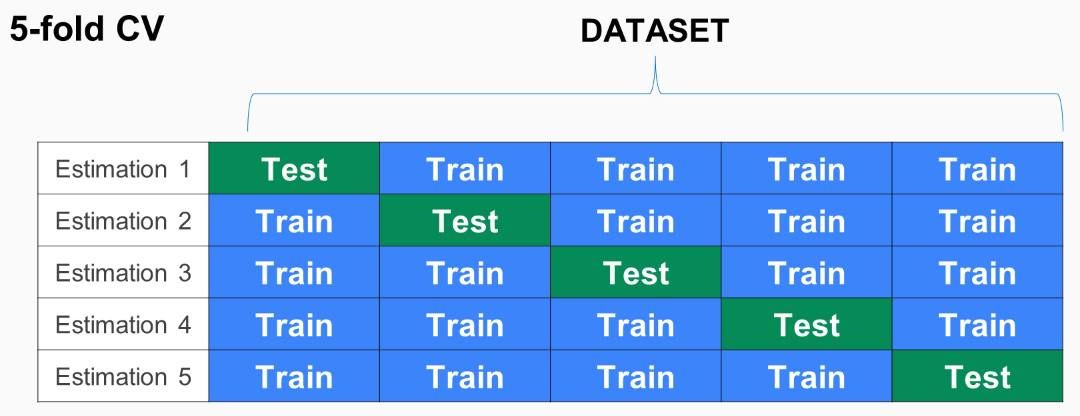

So here we would use the first 20% for testing and train on the remaining part, then we use the second 20% for testing and use the other 80% for training and so on. The goal is to find model hyperparameters that show a good and stable performance amongst all splits.

But how to determine performance in our case?

## Metrics for multi-class classification

### Confusion matrix
We can simply make a matrix with the true labels on the y-axis and the predicted labels on the x-axis. In our case this would be a 3 x 3 matrix. In each cell of the matrix we put the number of cases the specific constellation happened. E.g. in cell (y=1, x=2) we would put the number of times the model predicted 'Iris-versicolor' but the actual label was 'Iris-setosa'. The diagonal would contain all correct predictions.

### Accuracy
The accuracy is simply:
\begin{align}
Accuracy &= \frac{Number\,of\,correct\,predictions}{Total\,number\,of\,predictions}
\end{align}

### Many more...
Metrics for multi-class classification are vast. It really depends on the use case, the class balance, etc. which metrics make sense to use and you should have a look e.g. at [PyCM](https://www.pycm.ir/doc/) to get an overview.


Okay first of all write your own confusion matrix. There is already an empty dataframe that you only have to fill:

In [79]:
x_cols = df.columns[:3]
y_col = 'species'

shuffled = df.sample(frac=1, random_state=42)

train = shuffled[:120]
test = shuffled[120:]

clf = DecisionTree()
clf.fit(train, x_cols, y_col)
pred = clf.predict(test)

confusion_matrix = pd.DataFrame(index=df['species'].unique(),
                                columns=df['species'].unique(),
                                data = np.zeros((3,3)))
confusion_matrix.index.name = 'True'
confusion_matrix.columns.name = 'Predicted'


# 我和GPT太厉害啦
for true_label, pred_label in zip(pred[y_col], pred[f"{y_col}_pred"]):
    confusion_matrix.loc[true_label, pred_label] += 1
# raise NotImplementedError()

confusion_matrix

Predicted,Iris-setosa,Iris-versicolor,Iris-virginica
True,,,
Iris-setosa,7.0,0.0,0.0
Iris-versicolor,0.0,10.0,1.0
Iris-virginica,0.0,2.0,10.0


From you confusion matrix, how many wrong predictions were made by the model? Assign it to `answer`:

In [80]:
answer = int(confusion_matrix.values.sum() - np.trace(confusion_matrix.values))

In [81]:
assert answer or answer==0, "Please assign an answer!"

From your confusion matrix, how many samples were classified as Iris-versicolor by the model but were actually Iris-virginica? Assign it to `answer`:

In [ ]:
answer = (
    # YOUR CODE HERE
    raise NotImplementedError()
)

In [ ]:
assert answer or answer==0, "Please assign an answer!"

Okay now we can start tuning our model. First implement the accuracy calculation:

In [ ]:
def accuracy(df, y_col):
    # YOUR CODE HERE
    raise NotImplementedError()
    return acc

In [ ]:
assert accuracy(pred, y_col) == 0.9

## Hyperparameter tuning
Now let's vary the max_depth and the stop_n in a defined grid (below in the code) and do a 5-fold cross validation for each parameter combination. Work on the shuffled dataset without further reshuffling for the splits and write the mean accuracies to the `mean_accs` dataframe.

In [ ]:
x_cols = df.columns[:3]
y_col = 'species'

max_depths = [4, 7, 10]
stop_ns = [1, 3, 6]

shuffled = df.sample(frac=1, random_state=42)

mean_accs = pd.DataFrame(index=max_depths, columns=stop_ns)
mean_accs.index.name = "max depth"
mean_accs.columns.name = "stop n"

# YOUR CODE HERE
raise NotImplementedError()

mean_accs

In [ ]:
assert mean_accs.at[4, 1] == 0.9

In general in ML one tries to find a model with the best performance, in our case the highest accuracy, and the lowest complexity to avoid overfitting and reduce computational cost. Based on this, what combination of parameters would you choose for your decision tree?

In [ ]:
max_depth = (
    # YOUR CODE HERE
    raise NotImplementedError()
)
stop_n = (
    # YOUR CODE HERE
    raise NotImplementedError()
)

**Congratulations**, you reached the end of this exercise!

If you want to practice more we suggest:
- Dive deeper in classification metrics e.g. [here](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative).
- Implement the Gini Index yourself and add it as optional metric to the decision tree.
- Our implementation is hopelessly inefficient. Instead you can use sklearn and play around with their Decision Tree, KFold cross validation, accuracy metric, tree plotting, etc.
- Improve the model by continuing with random forests.

***Please do this in a separate notebook that is not submitted!***